In [69]:
! pip install numpy pandas PyQt6 gymnasium "gymnasium[other]" "gymnasium[classic-control]"

#### Imports

In [70]:
from typing import Optional
import numpy as np
import gymnasium as gym
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot as plt


#### World class

In [71]:
class GridWorldEnv(gym.Env):

    def __init__(self, size: int = 10):
        # The size of the square grid
        self.size = size
        self.trajectory = []
        self.world = np.zeros((size, size))

        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
                "agent": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = gym.spaces.Discrete(8)
        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            4: np.array([1, 1]),  # up-right
            5: np.array([-1, 1]),  # up-left
            6: np.array([-1, -1]),  # down-left
            7: np.array([1, -1]),  # down-right
        }
    def setReward(self, x, y , reward):
        self.world[x][y] = reward
    
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def getReward(self):
        return self.world[self._agent_location[0], self._agent_location[1]]

        

    def step(self, action):
        # Map the action (element of {0,1,2,3,4,5,6,7}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid bounds
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )

        # An environment is completed if and only if the agent has searched all states
        terminated = np.array_equal(self._agent_location, self._target_location)
        truncated = False
        reward = self.getReward()
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

#### Train Agent

In [72]:
class SAR_agent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))   # Q-values for each state-action pair

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.beta = 0.85
        self.trajectory = []

        self.training_error = []

    def reset_trajectory(self):
        self.trajectory = []

    def softmax_function(self):
        """"Softmax function to compute the probabilities of each action."""
        # We take an action based on the softmax function.
        # The softmax function is defined as the probability of taking an action.
        # We take the action with the highest probability.
        exp_q = np.exp(self.beta * self.q_values)  # Apply temperature scaling
        probabilities = exp_q / np.sum(exp_q)  # Normalize to create probability distribution
        return probabilities

    # def get_action(self):
    #     """Select an action based on the computed softmax probabilities."""
    #     probabilities = self.softmax_function()
    #     action = np.random.choice(len(self.q_values), p=probabilities)  # Takes a action based on the probabilites from the softmax policy
    #     return action

    def get_action(self, obs: dict) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # Convert agent's position to a tuple so it can be used as a dictionary key
        agent_state = tuple(obs['agent'])  

        # Ensure the state exists in the Q-table
        if agent_state not in self.q_values:
            self.q_values[agent_state] = np.zeros(self.env.action_space.n)

        # Exploration: With probability epsilon, take a random action
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # Exploitation: Take the best known action
        return int(np.argmax(self.q_values[agent_state]))


    def update(
        self,
        obs: dict,  # Changed to dict
        action: int,
        reward: float,
        terminated: bool,
        next_obs: dict,  # Changed to dict
    ):
        """Updates the Q-value of an action using Q-learning."""
        
        # Extract agent's position and convert to tuple (ensuring it's hashable)
        agent_state = tuple(obs['agent'])  
        next_agent_state = tuple(next_obs['agent'])  

        # Ensure both states exist in Q-table
        if agent_state not in self.q_values:
            self.q_values[agent_state] = np.zeros(self.env.action_space.n)
        if next_agent_state not in self.q_values:
            self.q_values[next_agent_state] = np.zeros(self.env.action_space.n)

        # Compute future Q-value
        future_q_value = (not terminated) * np.max(self.q_values[next_agent_state])

        # Compute temporal difference (TD) error
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[agent_state][action]
        )

        # Update Q-value
        self.q_values[agent_state][action] += self.lr * temporal_difference

        # Track training error
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
            self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)   # Decay epsilon to ensure exploration decreases over time
    
    
    def plot_trajectory(self):
        """Plot the agent's trajectory on a grid."""
        if not self.trajectory:
            print("No trajectory data to plot.")
            return

        # Extract x and y coordinates
        x_coords, y_coords = zip(*self.trajectory)

        plt.figure(figsize=(6, 6))
        plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Agent Path')

        # Mark start and end points
        plt.scatter(x_coords[0], y_coords[0], color='green', s=100, label='Start')  # Start position
        plt.scatter(x_coords[-1], y_coords[-1], color='red', s=100, label='End')    # End position

        # Grid & labels
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.xticks(range(min(x_coords) - 1, max(x_coords) + 2))
        plt.yticks(range(min(y_coords) - 1, max(y_coords) + 2))
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title("Agent Trajectory")
        plt.legend()
        plt.show()
        



In [73]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_0
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = GridWorldEnv(size=10)
env.setReward(1, 1, 7)
env.setReward(2, 2, 1)
env.setReward(3, 3, 10)
env.setReward(4, 4, 5)
env.setReward(5, 5, 1)
env.setReward(6, 6, 3)
env.setReward(7, 7, 3)
env.setReward(8, 8, 8)
env.setReward(9, 9, 2)

env = gym.wrappers.TimeLimit(env, max_episode_steps=100)

agent = SAR_agent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [74]:

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    agent.reset_trajectory()

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        # print(tuple(next_obs['agent']))
        agent.trajectory.append(tuple(next_obs['agent']))

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 1000/1000 [00:01<00:00, 759.79it/s]


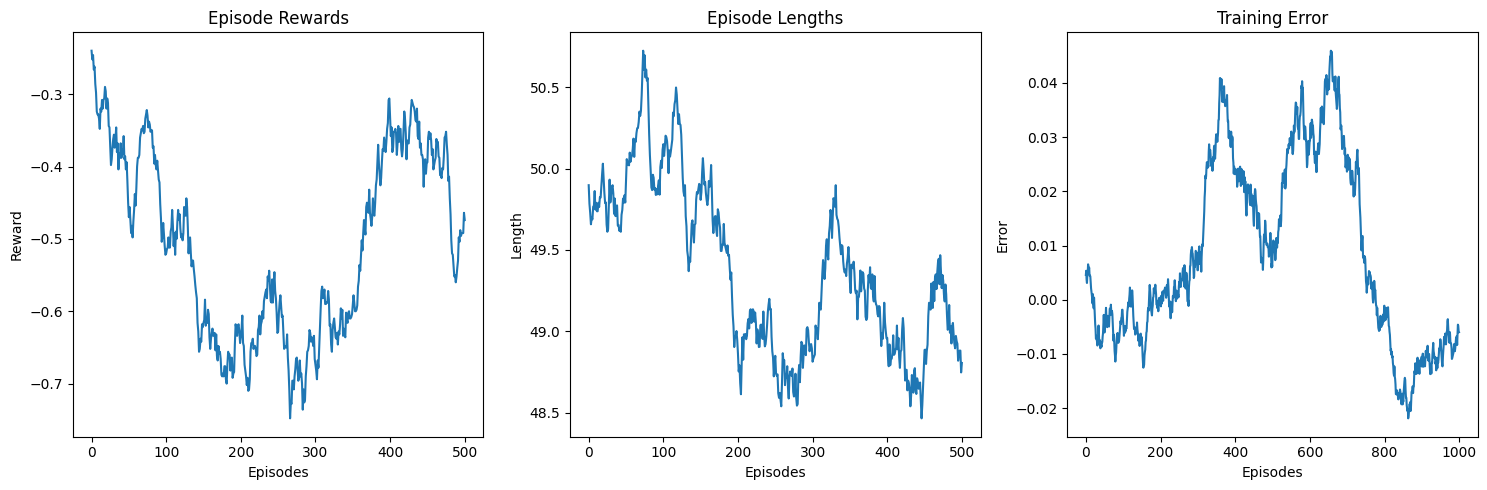

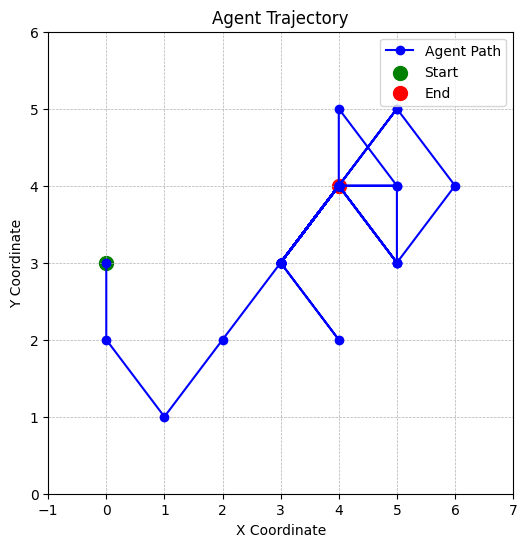

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Simulated episode rewards, lengths, and training errors
return_queue = [np.random.randint(-10, 10) for _ in range(1000)]  # Example rewards
length_queue = [np.random.randint(1, 100) for _ in range(1000)]   # Example episode lengths
training_error = [np.random.uniform(-1, 1) for _ in range(1000)]  # Example training errors

# Smooth over a 500 episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# Episode Rewards
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episodes")  # X-axis label
axs[0].set_ylabel("Reward")  # Y-axis label
reward_moving_average = get_moving_avgs(return_queue, rolling_length, "valid")
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

# Episode Lengths
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episodes")  # X-axis label
axs[1].set_ylabel("Length")  # Y-axis label
length_moving_average = get_moving_avgs(length_queue, rolling_length, "valid")
axs[1].plot(range(len(length_moving_average)), length_moving_average)

# Training Error
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episodes")  # X-axis label
axs[2].set_ylabel("Error")  # Y-axis label
training_error_moving_average = get_moving_avgs(training_error, rolling_length, "same")
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()
agent.plot_trajectory()



#### Record Agent
TODO:

In [76]:
# import gymnasium as gym
# from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# num_eval_episodes = 4

# env = GridWorldEnv(size=10)
# env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="eval",
#                   episode_trigger=lambda x: True)
# env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

# for episode_num in range(num_eval_episodes):
#     obs, info = env.reset()

#     episode_over = False
#     while not episode_over:
#         action = env.action_space.sample()  # replace with actual agent
#         obs, reward, terminated, truncated, info = env.step(action)

#         episode_over = terminated or truncated
# env.close()

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')
